# Prediction of the Currents Month Forward Price Using LSTM Models

# Methodology
- always went back to the best performming multivariate_lstm so far and adjusted from there


In [36]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import sys
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Get the directory of the current script
try:
    # This will work if the script is being run as a file
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Use the current working directory if __file__ is not defined
    current_dir = os.getcwd()
# Move up one directory level from EDA to the parent directory
parent_dir = os.path.dirname(current_dir)
# Construct the path to the xdrive folder
xdrive_path = os.path.join(parent_dir, 'xdrive')
# Add the xdrive path to sys.path
sys.path.append(xdrive_path)

featureeng_path = os.path.join(parent_dir, 'Feature Engineering')
# Add the xdrive path to sys.path
sys.path.append(featureeng_path)

# Construct the path to the xdrive folder
xdrive_path = os.path.join(parent_dir, 'Pipeline')
# Add the xdrive path to sys.path
sys.path.append(xdrive_path)
from build_a_pipeline import build_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from build_a_pipeline import build_pipeline_P0_foward_price

In [37]:
import os
import random
import numpy as np
import tensorflow as tf

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [38]:

model_performance = []
#x_train, x_val, X_test, y_train, y_val, y_test = build_pipeline_P0_foward_price(target_column = 'P0',deal_with_skewness = True)
#deal_with_skewness = True)
x_train, x_val, X_test, y_train, y_val, y_test = build_pipeline_P0_foward_price(drop_features=True, 
                                                                                remove_outliers = True, 
                                                                                percentage_of_outliers=0.01) #drop_features = False
datetime_index = x_val.index
#x_val = x_val.sort_index(ascending=True)
#y_val = y_val.sort_index(ascending=True)
# Convert x_train and x_val to NumPy arrays
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
# Reshape x_train and x_val to have the required 3D shape
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])  # [samples, time_steps=1, features]
x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])    
model_performance = [] 


## Multivariate LSTM multivariate_lstm 

- 200 Input Neurons on an Input Layer
- 2 Dense layers with 100 and 200 neurals
- relu function for activation

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

# Build the LSTM multivariate_lstm
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.4),
    Flatten(),
    Dense(50, activation='selu'),
    Dropout(0.4),
    Dense(50, activation='selu'),
    Dropout(0.4),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})

from tensorflow.keras.models import load_model
best_model = load_model('multivariate_lstm.keras')
y_pred = best_model.predict(x_val)
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")


Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 30727.6895 - root_mean_squared_error: 174.9711 - val_loss: 2217.0786 - val_root_mean_squared_error: 47.0859
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21327.8984 - root_mean_squared_error: 145.3526 - val_loss: 817.8824 - val_root_mean_squared_error: 28.5986
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11264.4141 - root_mean_squared_error: 105.5533 - val_loss: 214.8241 - val_root_mean_squared_error: 14.6569
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4857.3442 - root_mean_squared_error: 69.5308 - val_loss: 72.8350 - val_root_mean_squared_error: 8.5343
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2883.4470 - root_mean_squared_error: 53.4963 - val_loss: 25.1737 - val_root_mean_squared_error: 5.0173
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2623.8164 - root_mean_squared_error: 51.0121 - val_loss: 138.6514 - val_root_mean_squared_error: 11.7750
Epoch 7/120
17/17 ━━━━━

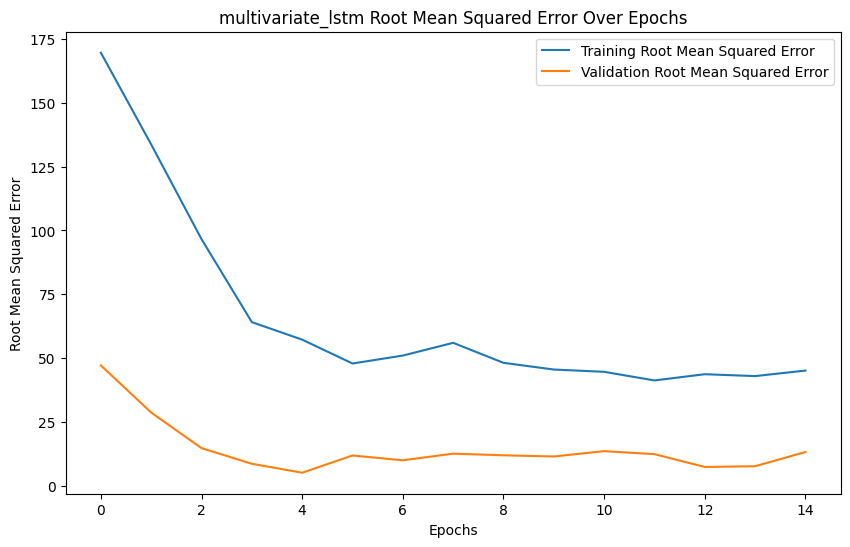

In [40]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['root_mean_squared_error'], label='Training Root Mean Squared Error')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Root Mean Squared Error')
plt.title('multivariate_lstm Root Mean Squared Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

## Multivariate LSTM 
- 300 neurons activation layer
- 3 activation layers

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Build the LSTM multivariate_lstm
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(300, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.4),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(200, activation='relu'),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)
# EarlyStopping to prevent overfitting
#early_stopping = EarlyStopping(monitor='mean_squared_error', patience=10, restore_best_weights=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})


Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 27192.7910 - root_mean_squared_error: 164.0033 - val_loss: 1189.4406 - val_root_mean_squared_error: 34.4883
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7000.5483 - root_mean_squared_error: 83.1012 - val_loss: 307.8769 - val_root_mean_squared_error: 17.5464
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4234.9072 - root_mean_squared_error: 64.9368 - val_loss: 443.0933 - val_root_mean_squared_error: 21.0498
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3010.4297 - root_mean_squared_error: 54.3896 - val_loss: 304.3142 - val_root_mean_squared_error: 17.4446
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2248.9856 - root_mean_squared_error: 47.3134 - val_loss: 413.6471 - val_root_mean_squared_error: 20.3383
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3902.0181 - root_mean_squared_error: 61.9980 - val_loss: 229.3818 - val_root_mean_squared_error: 15.1454
Epoch 7/120
17/17 ━━━

In [42]:

from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
R-squared: 0.6305227377454785


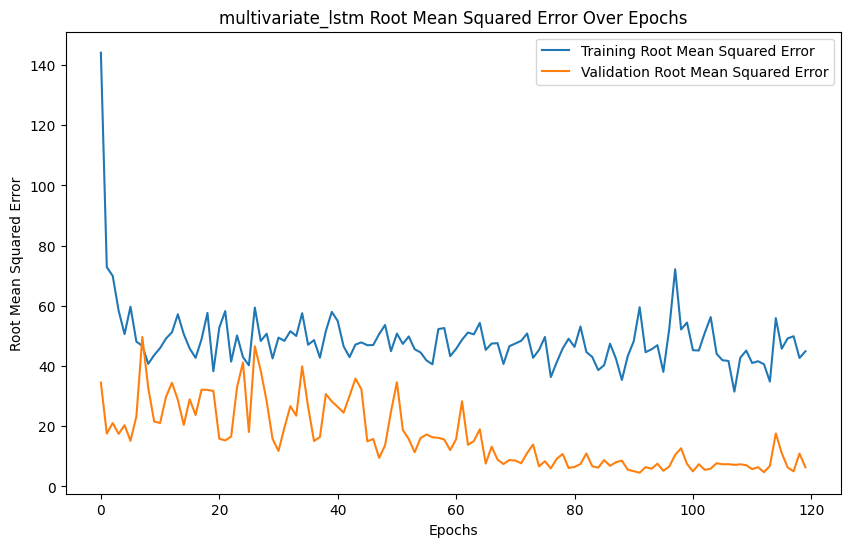

In [43]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['root_mean_squared_error'], label='Training Root Mean Squared Error')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Root Mean Squared Error')
plt.title('multivariate_lstm Root Mean Squared Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

This proved to have worse performence, then the previous multivariate_lstm

## Multivariate LSTM - Simplified
- 200 neurons input layer
- 1 Dense Layer

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Build the LSTM multivariate_lstm
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.4),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 30881.0547 - root_mean_squared_error: 175.4130 - val_loss: 3852.5122 - val_root_mean_squared_error: 62.0686
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19717.0840 - root_mean_squared_error: 139.6895 - val_loss: 1973.4421 - val_root_mean_squared_error: 44.4234
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8871.8486 - root_mean_squared_error: 94.1000 - val_loss: 110.1617 - val_root_mean_squared_error: 10.4958
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4054.7126 - root_mean_squared_error: 63.4376 - val_loss: 43.2537 - val_root_mean_squared_error: 6.5768
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1570.8916 - root_mean_squared_error: 39.6035 - val_loss: 68.1082 - val_root_mean_squared_error: 8.2528
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1469.7646 - root_mean_squared_error: 38.2949 - val_loss: 54.2529 - val_root_mean_squared_error: 7.3657
Epoch 7/120
17/17 ━━━━━━

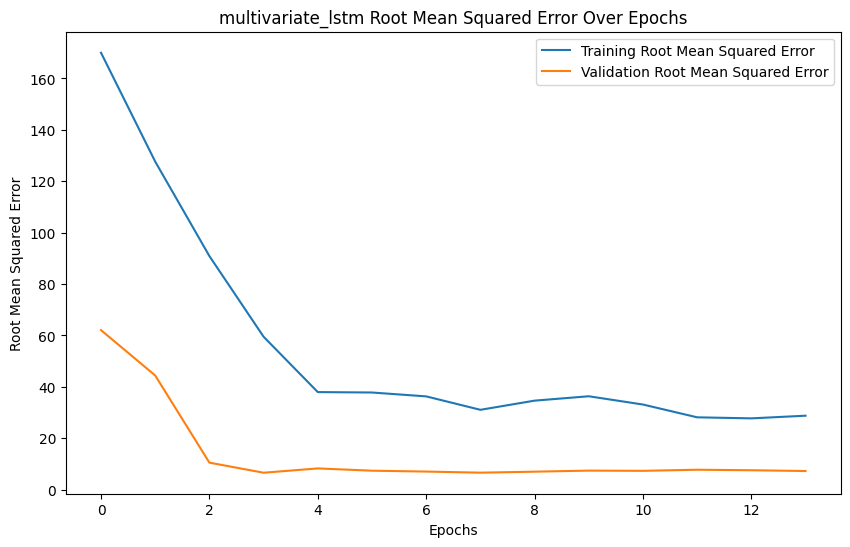

In [45]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['root_mean_squared_error'], label='Training Root Mean Squared Error')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Root Mean Squared Error')
plt.title('multivariate_lstm Root Mean Squared Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

Looks like simpler multivariate_lstm performed the best, therefore going this direction

## LSTM
- 300 input layers, 0.6 Dropout
- 200 dense layers, 0.5 Dropout
- keeping it only 3 layers, but increase amount of neurons

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Build the LSTM multivariate_lstm
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(300, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.6),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")
model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 29511.9609 - root_mean_squared_error: 171.3218 - val_loss: 2897.4143 - val_root_mean_squared_error: 53.8276
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10807.6475 - root_mean_squared_error: 103.2239 - val_loss: 34.7355 - val_root_mean_squared_error: 5.8937
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3973.4084 - root_mean_squared_error: 62.9322 - val_loss: 54.8484 - val_root_mean_squared_error: 7.4060
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1899.8533 - root_mean_squared_error: 43.5423 - val_loss: 60.7884 - val_root_mean_squared_error: 7.7967
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1081.8306 - root_mean_squared_error: 32.5882 - val_loss: 72.2893 - val_root_mean_squared_error: 8.5023
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1117.8396 - root_mean_squared_error: 33.3799 - val_loss: 67.1303 - val_root_mean_squared_error: 8.1933
Epoch 7/120
17/17 ━

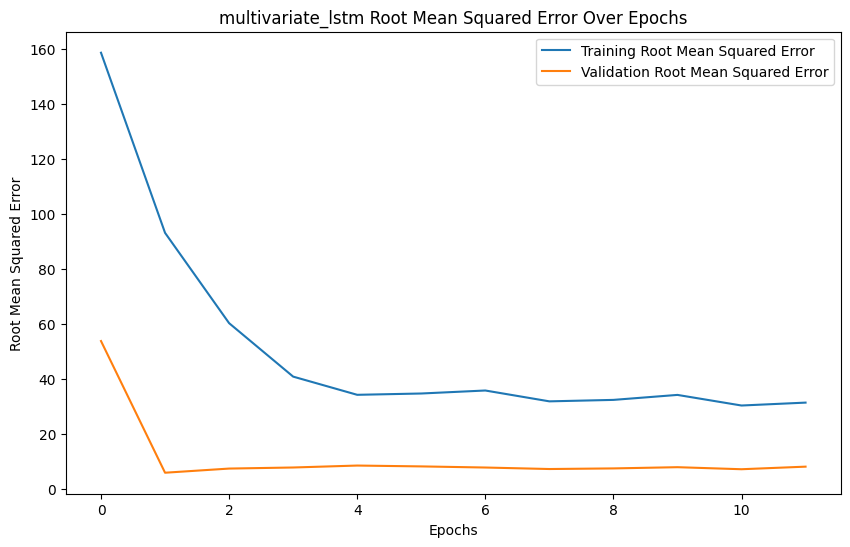

In [47]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['root_mean_squared_error'], label='Training Root Mean Squared Error')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Root Mean Squared Error')
plt.title('multivariate_lstm Root Mean Squared Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

LSTM multivariate_lstm
- 3 layers, changing the activation function to selu

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Build the LSTM multivariate_lstm
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.4),
    Flatten(),
    Dense(100, activation='selu'),
    Dropout(0.4),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 29899.9824 - root_mean_squared_error: 172.5267 - val_loss: 1545.3219 - val_root_mean_squared_error: 39.3106
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17293.4355 - root_mean_squared_error: 130.7438 - val_loss: 622.5864 - val_root_mean_squared_error: 24.9517
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8358.9189 - root_mean_squared_error: 91.1344 - val_loss: 118.9599 - val_root_mean_squared_error: 10.9069
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2688.7053 - root_mean_squared_error: 51.5612 - val_loss: 62.2817 - val_root_mean_squared_error: 7.8919
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1315.7432 - root_mean_squared_error: 36.0555 - val_loss: 73.2584 - val_root_mean_squared_error: 8.5591
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1047.7867 - root_mean_squared_error: 32.3055 - val_loss: 100.2068 - val_root_mean_squared_error: 10.0103
Epoch 7/120
17/17 ━━━━━

## Adding One More Layer, trying selu and relu together

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Build the LSTM multivariate_lstm
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.4),
    Dense(200, activation = 'relu'),
    Dropout(0.6),
    Flatten(),
    Dense(100, activation='selu'),
    Dropout(0.4),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 26891.4043 - root_mean_squared_error: 163.0073 - val_loss: 1707.3964 - val_root_mean_squared_error: 41.3207
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6728.2563 - root_mean_squared_error: 81.8716 - val_loss: 95.4153 - val_root_mean_squared_error: 9.7681
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2784.4800 - root_mean_squared_error: 52.6648 - val_loss: 105.6949 - val_root_mean_squared_error: 10.2808
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2291.4919 - root_mean_squared_error: 47.4409 - val_loss: 212.4029 - val_root_mean_squared_error: 14.5740
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2019.3890 - root_mean_squared_error: 44.3407 - val_loss: 121.4105 - val_root_mean_squared_error: 11.0186
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1743.3591 - root_mean_squared_error: 41.5190 - val_loss: 78.0307 - val_root_mean_squared_error: 8.8335
Epoch 7/120
17/17 ━━━━━━━━

## TimeDistributed Layer Expiriment
- selu function

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

# Build the LSTM multivariate_lstm
multivariate_lstm = Sequential([
    LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    TimeDistributed(Dense(100, activation='selu')), 
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")
model_performance.append({
    'multivariate_lstm': 'LSTM - 200 input',
    'LayerExtra': 'TimeDistributed, Dense, Relu',
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 29415.6191 - root_mean_squared_error: 171.0558 - val_loss: 573.4482 - val_root_mean_squared_error: 23.9468
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13002.9160 - root_mean_squared_error: 113.1921 - val_loss: 1130.7583 - val_root_mean_squared_error: 33.6268
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4497.7617 - root_mean_squared_error: 66.7660 - val_loss: 88.7122 - val_root_mean_squared_error: 9.4187
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 940.1182 - root_mean_squared_error: 30.5184 - val_loss: 227.3681 - val_root_mean_squared_error: 15.0787
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 483.9544 - root_mean_squared_error: 21.9486 - val_loss: 213.6484 - val_root_mean_squared_error: 14.6167
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 338.2485 - root_mean_squared_error: 18.3544 - val_loss: 170.0727 - val_root_mean_squared_error: 13.0412
Epoch 7/120
17/17 ━━━━━━━━━

## TimeDistributed
- relu function

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

# Build the LSTM multivariate_lstm
multivariate_lstm = Sequential([
    LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    TimeDistributed(Dense(100, activation='relu')), 
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 30223.9766 - root_mean_squared_error: 173.4807 - val_loss: 4242.8037 - val_root_mean_squared_error: 65.1368
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16924.8301 - root_mean_squared_error: 129.3424 - val_loss: 3363.2004 - val_root_mean_squared_error: 57.9931
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7996.9131 - root_mean_squared_error: 89.2025 - val_loss: 371.2634 - val_root_mean_squared_error: 19.2682
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2852.3203 - root_mean_squared_error: 53.0636 - val_loss: 114.8198 - val_root_mean_squared_error: 10.7154
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 659.5898 - root_mean_squared_error: 25.6547 - val_loss: 173.1494 - val_root_mean_squared_error: 13.1586
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 361.1738 - root_mean_squared_error: 18.9700 - val_loss: 332.2706 - val_root_mean_squared_error: 18.2283
Epoch 7/120
17/17 ━

## Time Distributed Layers - 2
- 2 layers, relu and selu

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

# Build the LSTM multivariate_lstm
multivariate_lstm = Sequential([
    LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    TimeDistributed(Dense(100, activation='relu')), 
    Dropout(0.3),
    TimeDistributed(Dense(100, activation='selu')), 
    Dropout(0.3),
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")
model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 27726.8711 - root_mean_squared_error: 165.7041 - val_loss: 1047.0302 - val_root_mean_squared_error: 32.3578
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7819.3008 - root_mean_squared_error: 88.2609 - val_loss: 159.2803 - val_root_mean_squared_error: 12.6206
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2257.8032 - root_mean_squared_error: 47.2409 - val_loss: 161.1507 - val_root_mean_squared_error: 12.6945
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1078.6520 - root_mean_squared_error: 32.7252 - val_loss: 153.7184 - val_root_mean_squared_error: 12.3983
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 729.2086 - root_mean_squared_error: 26.9422 - val_loss: 129.7744 - val_root_mean_squared_error: 11.3919
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1084.4935 - root_mean_squared_error: 32.7536 - val_loss: 148.7289 - val_root_mean_squared_error: 12.1954
Epoch 7/120
17/17 ━━━━

More layers did not seem to improve the performance

## Timedistributed, 4 layers

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

# Build the LSTM multivariate_lstm
multivariate_lstm = Sequential([
    LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    TimeDistributed(Dense(200, activation='selu')), 
    Dropout(0.3),
    TimeDistributed(Dense(100, activation='selu')), 
    Dropout(0.3),
    TimeDistributed(Dense(50, activation='selu')), 
    Dropout(0.3),
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")

C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 25685.6523 - root_mean_squared_error: 159.0719 - val_loss: 2460.9333 - val_root_mean_squared_error: 49.6078
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4691.3784 - root_mean_squared_error: 67.9406 - val_loss: 745.1092 - val_root_mean_squared_error: 27.2967
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2252.7827 - root_mean_squared_error: 47.3424 - val_loss: 591.8329 - val_root_mean_squared_error: 24.3276
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1275.3385 - root_mean_squared_error: 35.6173 - val_loss: 662.9734 - val_root_mean_squared_error: 25.7483
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1612.0447 - root_mean_squared_error: 39.9621 - val_loss: 143.3590 - val_root_mean_squared_error: 11.9733
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1677.0282 - root_mean_squared_error: 40.8644 - val_loss: 186.3447 - val_root_mean_squared_error: 13.6508
Epoch 7/1

Adding extra layers did not seem to improve performance

## NO LSTM, Time Distributed layers only

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

# Build the LSTM multivariate_lstm
multivariate_lstm = Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=(x_train.shape[1], x_train.shape[2]),),
    TimeDistributed(Dense(200, activation='selu')), 
    Dropout(0.3),
    TimeDistributed(Dense(100, activation='selu')), 
    Dropout(0.3),
    TimeDistributed(Dense(50, activation='selu')), 
    Dropout(0.3),
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 22073.3125 - root_mean_squared_error: 146.5978 - val_loss: 1153.5922 - val_root_mean_squared_error: 33.9646
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4125.4990 - root_mean_squared_error: 63.6770 - val_loss: 3439.9858 - val_root_mean_squared_error: 58.6514
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2558.0332 - root_mean_squared_error: 50.4521 - val_loss: 2688.5437 - val_root_mean_squared_error: 51.8512
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1475.3250 - root_mean_squared_error: 38.2200 - val_loss: 1203.3462 - val_root_mean_squared_error: 34.6893
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2161.2976 - root_mean_squared_error: 46.3874 - val_loss: 3582.3186 - val_root_mean_squared_error: 59.8525
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1735.7897 - root_mean_squared_error: 41.2384 - val_loss: 2411.4456 - val_root_mean_squared_error: 49.1065
Epoch 7/120
17/17 ━

Time Distributed MLP
- inspired by https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

# Build the LSTM multivariate_lstm
multivariate_lstm = Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=(x_train.shape[1], x_train.shape[2]),),
    TimeDistributed(Dense(150, activation='relu')), 
    TimeDistributed(Dense(100, activation='relu')), 
    TimeDistributed(Dense(50, activation='relu')), 
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=2e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 30678.7285 - root_mean_squared_error: 174.8027 - val_loss: 9315.8467 - val_root_mean_squared_error: 96.5186
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9764.1738 - root_mean_squared_error: 97.3359 - val_loss: 1431.2477 - val_root_mean_squared_error: 37.8318
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2933.1758 - root_mean_squared_error: 53.9257 - val_loss: 17568.1016 - val_root_mean_squared_error: 132.5447
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1514.0959 - root_mean_squared_error: 38.8605 - val_loss: 11555.1357 - val_root_mean_squared_error: 107.4948
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 982.8218 - root_mean_squared_error: 31.3224 - val_loss: 13660.5459 - val_root_mean_squared_error: 116.8783
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 616.9498 - root_mean_squared_error: 24.8161 - val_loss: 13049.0645 - val_root_mean_squared_error: 114.2325
Epoch 7/120


In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

# Build the LSTM multivariate_lstm
multivariate_lstm = Sequential([
    TimeDistributed(Dense(500, activation='relu'),
                    input_shape=(x_train.shape[1], x_train.shape[2]),),
    TimeDistributed(Dense(400, activation='relu')), 
    TimeDistributed(Dense(300, activation='relu')), 
    TimeDistributed(Dense(100, activation='relu')), 
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=2e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")
model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")

C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 24181.9199 - root_mean_squared_error: 153.7800 - val_loss: 811.7007 - val_root_mean_squared_error: 28.4904
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4114.6987 - root_mean_squared_error: 63.9899 - val_loss: 17322.0117 - val_root_mean_squared_error: 131.6131
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1355.7068 - root_mean_squared_error: 36.6462 - val_loss: 9484.7637 - val_root_mean_squared_error: 97.3897
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 728.9123 - root_mean_squared_error: 26.9027 - val_loss: 11927.2529 - val_root_mean_squared_error: 109.2120
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 437.0957 - root_mean_squared_error: 20.8750 - val_loss: 11268.0303 - val_root_mean_squared_error: 106.1510
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 417.4874 - root_mean_squared_error: 20.1981 - val_loss: 13691.1680 - val_root_mean_squared_error: 117.009

Back to simple LSTM

## LSTM multivariate_lstm 
- simple again

In [57]:
input_shape = (x_train.shape[1], x_train.shape[2])

In [58]:
import tensorflow as tf

# Resetting the backend
tf.keras.backend.clear_session()

# Define multivariate_lstm
input_shape = (x_train.shape[1], x_train.shape[2])  # Ensure input_shape matches data
multivariate_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(500, input_shape=input_shape, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

# Checkpoint Callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'multivariate_lstm.keras',  # Use `.keras` extension
    monitor='val_loss',
    save_best_only=True
)

# Optimizer with updated parameter
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")
model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 28537.3984 - root_mean_squared_error: 168.2969 - val_loss: 1214.5726 - val_root_mean_squared_error: 34.8507
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8495.4346 - root_mean_squared_error: 91.8942 - val_loss: 28.6393 - val_root_mean_squared_error: 5.3516
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3221.6113 - root_mean_squared_error: 56.4109 - val_loss: 80.1832 - val_root_mean_squared_error: 8.9545
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 716.5700 - root_mean_squared_error: 26.7297 - val_loss: 66.0362 - val_root_mean_squared_error: 8.1263
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 441.0443 - root_mean_squared_error: 20.9181 - val_loss: 76.3539 - val_root_mean_squared_error: 8.7381
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 353.5422 - root_mean_squared_error: 18.7147 - val_loss: 56.7877 - val_root_mean_squared_error: 7.5358
Epoch 7/120
17/17 ━━

## LSTM - increase the amount of neurons

In [59]:
import tensorflow as tf

# Resetting the backend
tf.keras.backend.clear_session()

# Define multivariate_lstm
input_shape = (x_train.shape[1], x_train.shape[2])  # Ensure input_shape matches data
multivariate_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(500, input_shape=input_shape, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Checkpoint Callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'multivariate_lstm.keras',  # Use `.keras` extension
    monitor='val_loss',
    save_best_only=True
)

# Optimizer with updated parameter
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 22997.2070 - root_mean_squared_error: 149.6302 - val_loss: 140.3762 - val_root_mean_squared_error: 11.8480
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4544.4585 - root_mean_squared_error: 66.2595 - val_loss: 156.3010 - val_root_mean_squared_error: 12.5020
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1110.4741 - root_mean_squared_error: 33.3004 - val_loss: 1106.0571 - val_root_mean_squared_error: 33.2574
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 799.4267 - root_mean_squared_error: 28.2652 - val_loss: 310.6522 - val_root_mean_squared_error: 17.6253
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 552.5195 - root_mean_squared_error: 23.3980 - val_loss: 558.4603 - val_root_mean_squared_error: 23.6318
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 477.8775 - root_mean_squared_error: 21.7079 - val_loss: 647.8057 - val_root_mean_squared_error: 25.4520
Epoch 7/12

## 2 LSTM Layers

In [60]:
import tensorflow as tf

# Resetting the backend
tf.keras.backend.clear_session()

# Define multivariate_lstm
input_shape = (x_train.shape[1], x_train.shape[2])  # Ensure input_shape matches data
multivariate_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(500, input_shape=input_shape, return_sequences=True),
    tf.keras.layers.LSTM(200, return_sequences=False),  # Second LSTM
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Checkpoint Callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'multivariate_lstm.keras',  # Use `.keras` extension
    monitor='val_loss',
    save_best_only=True
)

# Optimizer with updated parameter
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")
model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})
from tensorflow.keras.models import load_model
#best_model = load_model('multivariate_lstm.keras')
y_pred = multivariate_lstm.predict(x_val)
y_pred = y_pred.flatten()  # or y_pred.squeeze() if necessary
r_squared = r2_score(y_val, y_pred)
print(f"R-squared: {r_squared}")


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - loss: 23405.1113 - root_mean_squared_error: 151.1663 - val_loss: 2119.7527 - val_root_mean_squared_error: 46.0408
Epoch 2/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4267.4727 - root_mean_squared_error: 64.9840 - val_loss: 231.2295 - val_root_mean_squared_error: 15.2062
Epoch 3/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1975.4668 - root_mean_squared_error: 44.1370 - val_loss: 286.5290 - val_root_mean_squared_error: 16.9272
Epoch 4/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1327.7872 - root_mean_squared_error: 36.3095 - val_loss: 50.8325 - val_root_mean_squared_error: 7.1297
Epoch 5/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1286.6772 - root_mean_squared_error: 35.7477 - val_loss: 176.4430 - val_root_mean_squared_error: 13.2832
Epoch 6/120
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 682.2158 - root_mean_squared_error: 26.0844 - val_loss: 97.1664 - val_root_mean_squared_error: 9.8573
Epoch 7/12

In [61]:
from tensorflow.keras.models import load_model
best_model = load_model('multivariate_lstm.keras')
y_pred = best_model.predict(x_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step


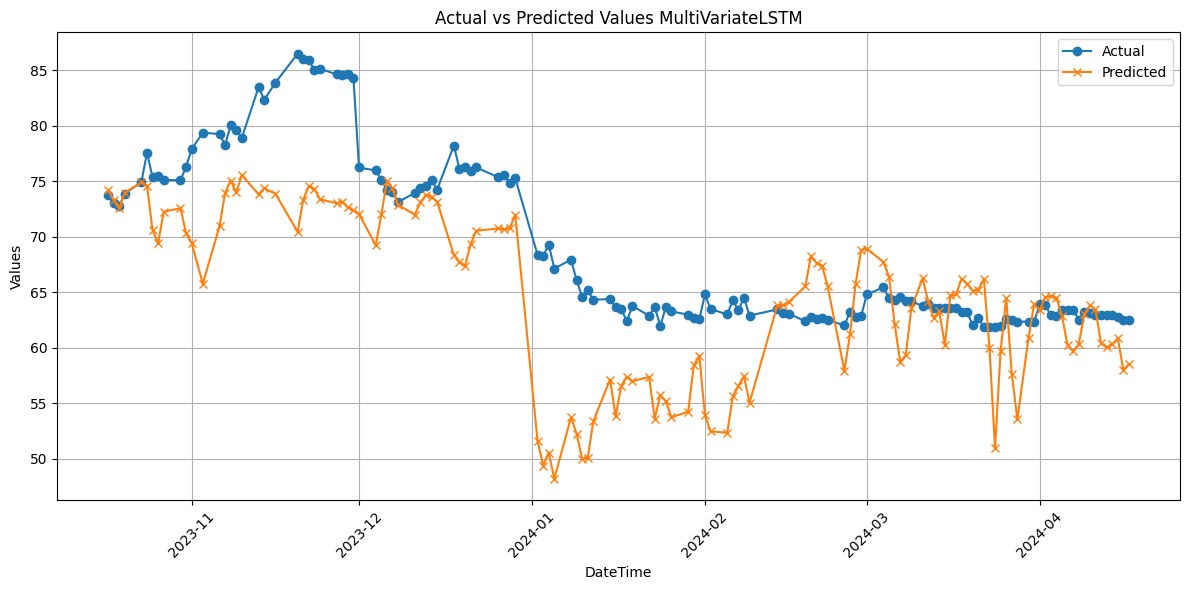

In [62]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

y_pred = y_pred.flatten()
predictions_df = pd.DataFrame(y_pred, index=datetime_index, columns=['Predicted'])
predictions_df = predictions_df.sort_index()
y_val = y_val.sort_index()

# Plotting y_actual vs y_pred
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label='Actual', marker='o')
plt.plot(y_val.index, predictions_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values MultiVariateLSTM')
plt.xlabel('DateTime')
plt.ylabel('Values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [63]:
performance_df = pd.DataFrame(model_performance)
performance_df_sorted = performance_df.sort_values(by='Validation RMSE', ascending=True)
performance_df_sorted

,multivariate_lstm,Train RMSE,Validation RMSE,LayerExtra
13,"<Sequential name=sequential, built=True>",13.413706,5.607556,NaN
10,"<Sequential name=sequential_25, built=True>",36.523827,6.116383,NaN
7,"<Sequential name=sequential_22, built=True>",9.847792,6.194900,NaN
1,"<Sequential name=sequential_16, built=True>",44.897606,6.360499,NaN
9,"<Sequential name=sequential_24, built=True>",27.877934,6.941047,NaN
2,"<Sequential name=sequential_17, built=True>",28.766548,7.240141,NaN
3,"<Sequential name=sequential_18, built=True>",31.411175,8.101914,NaN
5,"<Sequential name=sequential_20, built=True>",39.240520,9.985173,NaN
8,"<Sequential name=sequential_23, built=True>",24.356615,10.218453,NaN
4,"<Sequential name=sequential_19, built=True>",27.891663,12.823805,NaN
